# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Regression</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [1151]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [1152]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [1153]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [1154]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [1155]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [1156]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [1157]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [1158]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [1159]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [1160]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [1161]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-07-05,9138.5,9143.5,8915.1,9083.8,9042.2,1933.66216977,6980
1,2020-07-06,9083.8,9372.0,9065.2,9348.2,9261.3,4710.44847333,14341
2,2020-07-07,9347.1,9378.0,9204.1,9256.8,9281.5,3589.57391325,11121


In [1162]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-06-22,20704.1,20860.1,19750.0,19951.3,20272.0,6091.94667736,33996
718,2022-06-23,19951.3,21200.0,19880.4,21086.7,20580.2,3813.63775847,26182
719,2022-06-24,21090.8,21166.5,20975.1,21023.4,21063.0,47.54300524,845


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [1163]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-07-05,9138.5,9143.5,8915.1,9083.8,1933.66216977,6980
1,2020-07-06,9083.8,9372.0,9065.2,9348.2,4710.44847333,14341
2,2020-07-07,9347.1,9378.0,9204.1,9256.8,3589.57391325,11121


<b> Select the data after March 31,2022 </b>

In [1164]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [1165]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [1166]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [1167]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3169,2022-06-22,20704.1,20860.1,19750.0,19951.3,6091.94667736,33996
3170,2022-06-23,19951.3,21200.0,19880.4,21086.7,3813.63775847,26182
3171,2022-06-24,21090.8,21166.5,20975.1,21023.4,47.54300524,845


In [1168]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3172 entries, 0 to 3171
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3172 non-null   datetime64[ns]
 1   open    3172 non-null   object        
 2   high    3172 non-null   object        
 3   low     3172 non-null   object        
 4   close   3172 non-null   object        
 5   volume  3172 non-null   object        
 6   trades  3172 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 173.6+ KB


In [1169]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [1170]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [1171]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [1172]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [1173]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3170,2022-06-23,19951.3,21200.0,19880.4,21086.7,3813.637758,26182
3171,2022-06-24,21090.8,21166.5,20975.1,21023.4,47.543005,845


In [1174]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3172 entries, 0 to 3171
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3172 non-null   object 
 1   open    3172 non-null   float64
 2   high    3172 non-null   float64
 3   low     3172 non-null   float64
 4   close   3172 non-null   float64
 5   volume  3172 non-null   float64
 6   trades  3172 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 198.2+ KB


#### Split date column to year, month, day

In [1175]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [1176]:
btc_df = date_split(btc_df)

In [1177]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [1178]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [1179]:
btc_df = btc_df.set_index("date")

In [1180]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [1181]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [1182]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [1183]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [1184]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [1185]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [1186]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [1187]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [1188]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [1189]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [1190]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [1191]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [1192]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1193]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,2022,6,22,20704.1,20860.1,19750.0,19951.3,6091.946677,33996,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,2022,6,23,19951.3,21200.0,19880.4,21086.7,3813.637758,26182,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926
2022-06-24,2022,6,24,21090.8,21166.5,20975.1,21023.4,47.543005,845,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.036360,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.026140,20572.688889,24810.430,28274.004


#### Drop NaN

In [1194]:
len(btc_df)

3172

In [1195]:
btc_df = btc_df.dropna()

In [1196]:
len(btc_df)

3122

In [1197]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [1198]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,2022,6,22,20704.1,20860.1,19750.0,19951.3,6091.946677,33996,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,2022,6,23,19951.3,21200.0,19880.4,21086.7,3813.637758,26182,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926
2022-06-24,2022,6,24,21090.8,21166.5,20975.1,21023.4,47.543005,845,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.036360,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.026140,20572.688889,24810.430,28274.004


#### Save dataframe for later use for Machine Learaning model

In [1199]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [1200]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [1201]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,2022,6,22,20704.1,20860.1,19750.0,19951.3,6091.946677,33996,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,2022,6,23,19951.3,21200.0,19880.4,21086.7,3813.637758,26182,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926
2022-06-24,2022,6,24,21090.8,21166.5,20975.1,21023.4,47.543005,845,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.036360,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.026140,20572.688889,24810.430,28274.004


In [1202]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [1203]:
btc_df_viz.to_csv("data/btc_df_viz.csv")
btc_df_viz.to_excel("data/btc_df_viz.xlsx")

In [1204]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [1205]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-21,2022,6,21,20551.2,21698.9,20323.6,20701.9,5232.173565,33111,20550.1,21038.3,19625.0,20550.0,7167.610276,37760.0,0.084438,0.011462,0.095695,-0.000268,-0.252259,-0.170092,21062.671429,21848.257143,19497.185714,20789.328571,9901.941296,49320.714286,-0.054407,-0.042910,-0.051957,-0.033104,0.550911,0.305346,21617.222222,26218.105,29357.418
2022-06-22,2022,6,22,20704.1,20860.1,19750.0,19951.3,6091.946677,33996,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,2022,6,23,19951.3,21200.0,19880.4,21086.7,3813.637758,26182,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926


<b> Close Price Trend </b>

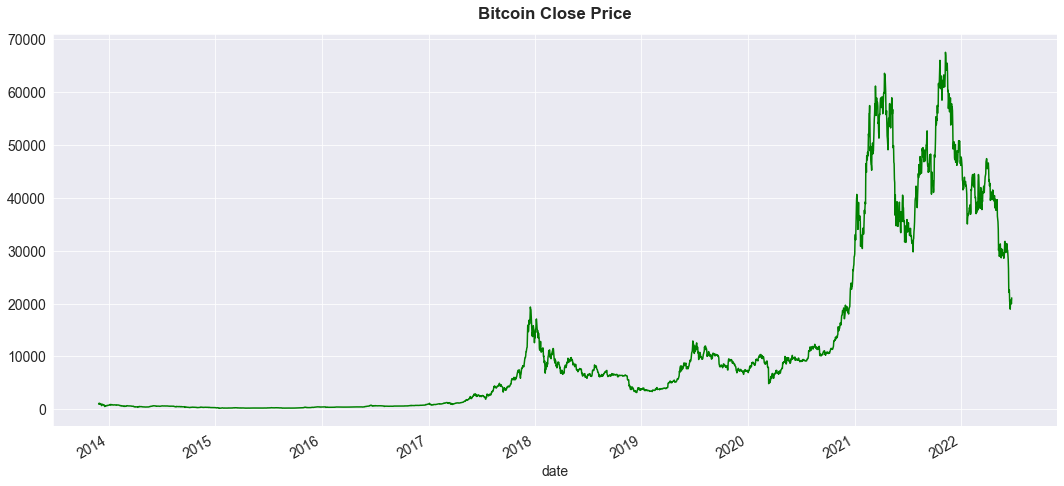

In [1206]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

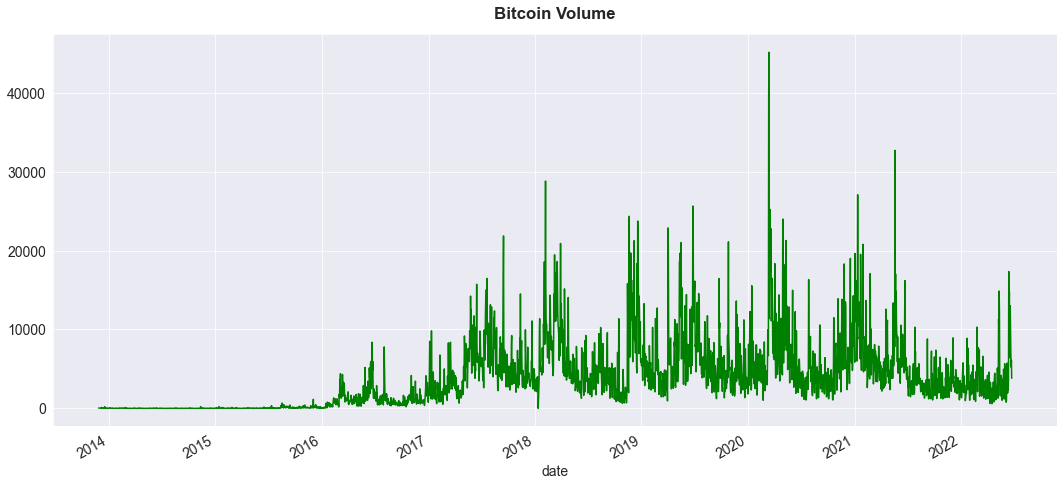

In [1207]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

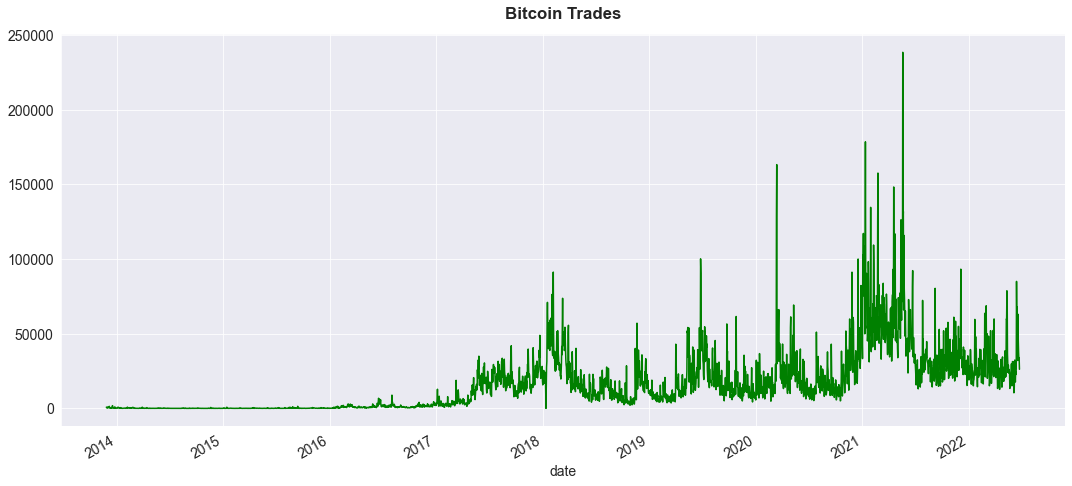

In [1208]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

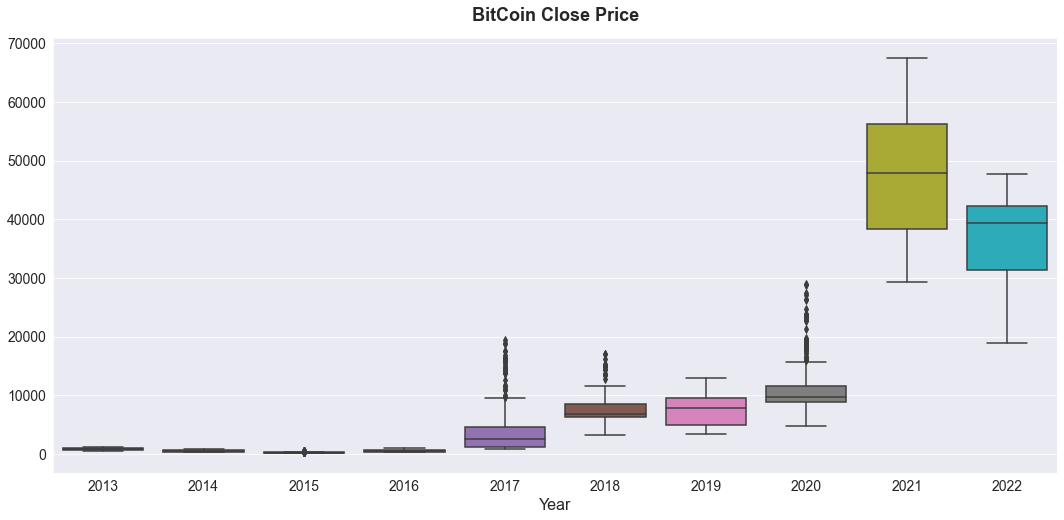

In [1209]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

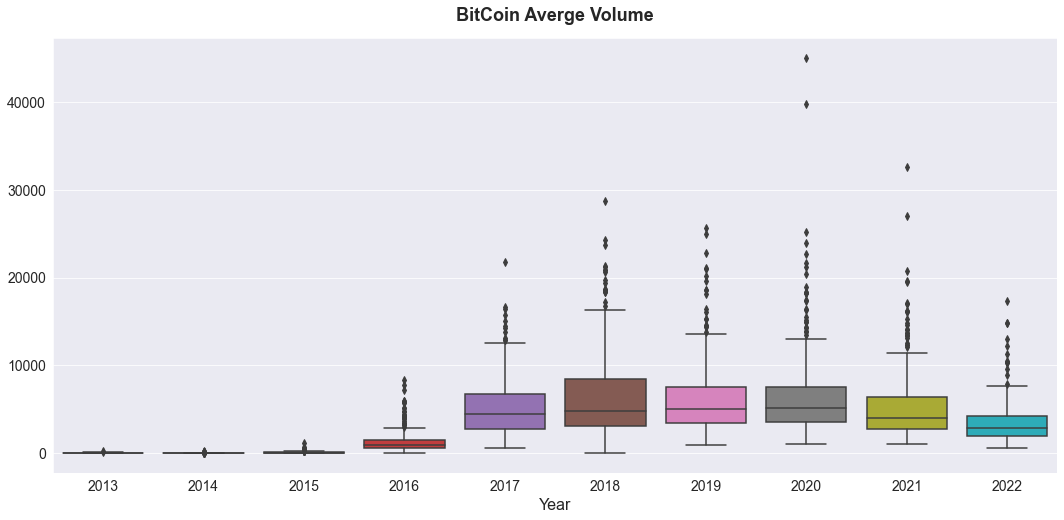

In [1210]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

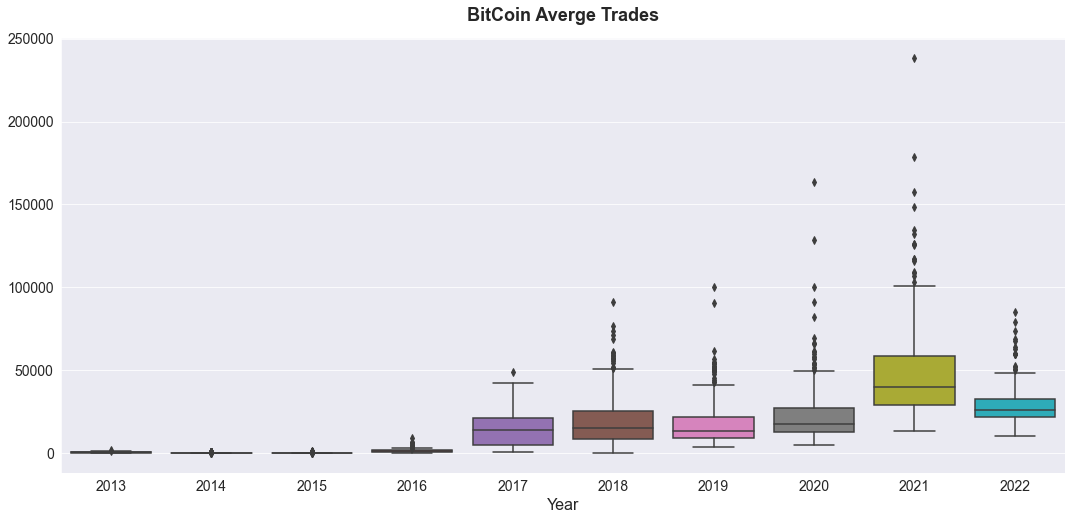

In [1211]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [1212]:
btc_df_viz_2022 = btc_df_viz[:]

In [1213]:
filt = btc_df_viz_2022["year"]='2022'

In [1214]:
btc_df_viz_2022 = btc_df_viz_2022[filt]

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/3275679836.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022 = btc_df_viz_2022[filt]


In [1215]:
btc_df_viz_2022.to_csv("data/btc_df_viz_2022.csv")
btc_df_viz_2022.to_excel("data/btc_df_viz_2022.xlsx")

Text(0, 0.5, '')

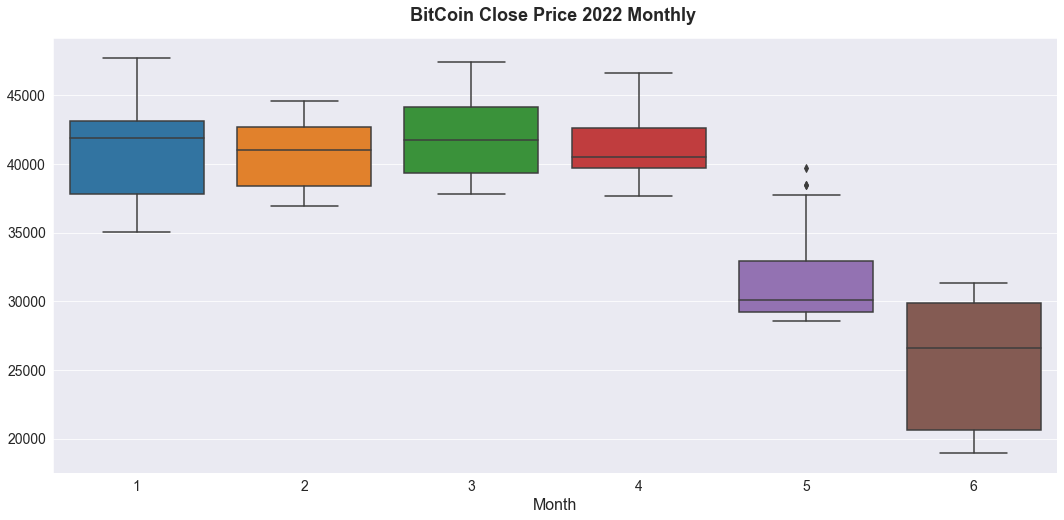

In [1216]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [1217]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [1218]:
btc_avg = btc_df_viz[:]
btc_avg.to_csv("data/btc_avg.csv")
btc_avg.to_excel("data/btc_avg.xlsx")
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-19,2022,6,19,18950.00000,20799.90000,17911.00000,20555.50000,9585.688357,45499,20440.30000,20740.10000,17600.00000,18950.00000,13006.203311,63068.0,0.003633,-0.027528,-0.130061,-0.072574,1.030896,0.966450,23268.100000,23779.085714,21054.457143,21921.357143,10508.632172,53358.714286,-0.052644,-0.048128,-0.047694,-0.047271,0.457558,0.220289,23431.622222,27337.460000,30058.006000
2022-06-20,2022,6,20,20550.10000,21038.30000,19625.00000,20550.00000,7167.610276,37760,18950.00000,20799.90000,17911.00000,20555.50000,9585.688357,45499.0,-0.072910,0.002883,0.017670,0.084723,-0.262991,-0.278572,21918.685714,22678.957143,19826.528571,21062.200000,11354.209559,56079.000000,-0.047238,-0.047747,-0.062563,-0.054321,0.671629,0.368859,22487.244444,26779.650000,29715.900000
2022-06-21,2022,6,21,20551.20000,21698.90000,20323.60000,20701.90000,5232.173565,33111,20550.10000,21038.30000,19625.00000,20550.00000,7167.610276,37760.0,0.084438,0.011462,0.095695,-0.000268,-0.252259,-0.170092,21062.671429,21848.257143,19497.185714,20789.328571,9901.941296,49320.714286,-0.054407,-0.042910,-0.051957,-0.033104,0.550911,0.305346,21617.222222,26218.105000,29357.418000


In [1219]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

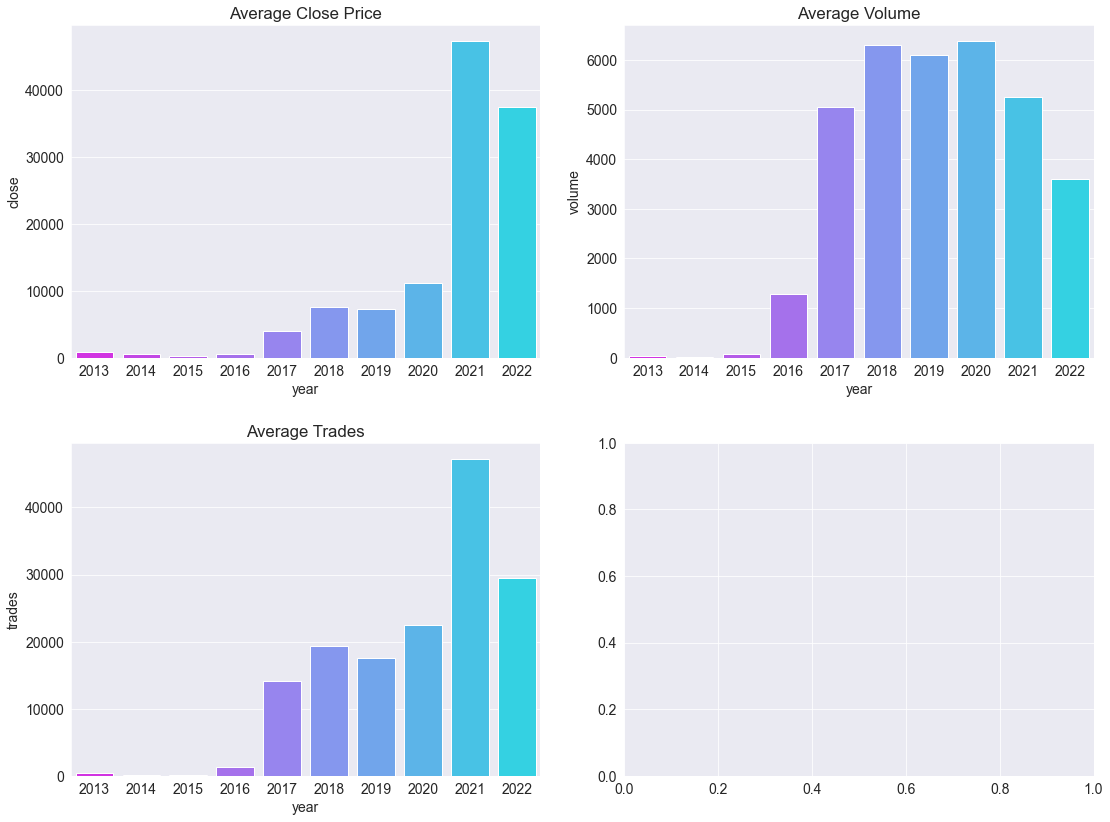

In [1220]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [1221]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [1222]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

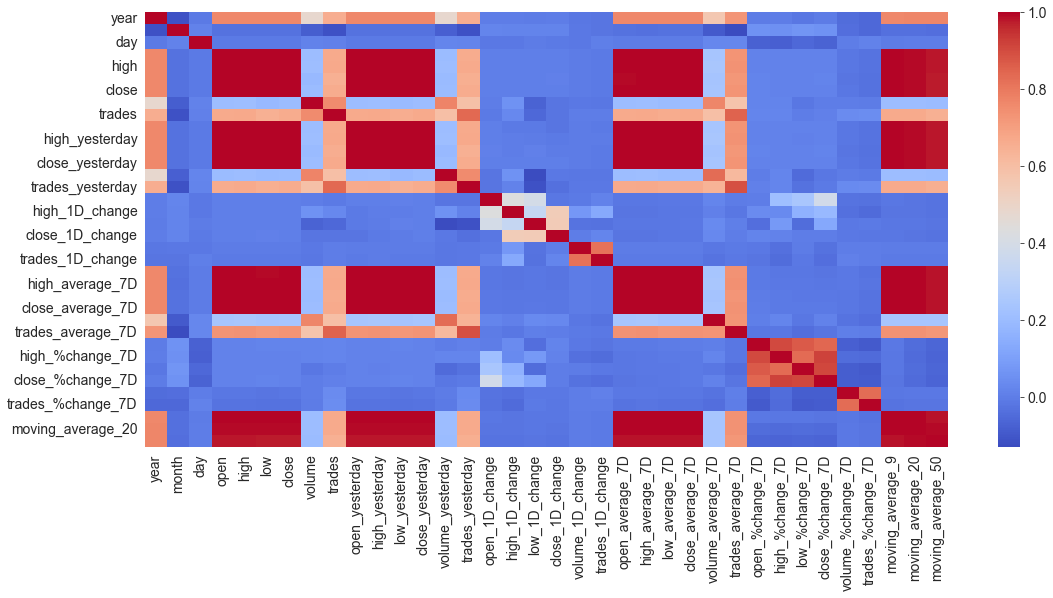

In [1223]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [1224]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [1225]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [1226]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [1227]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [1228]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [1229]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [1230]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,19951.3,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,21086.7,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926
2022-06-24,21023.4,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.036360,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.026140,20572.688889,24810.430,28274.004


#### Drop the last row because we want to predict the price of the current day

In [1231]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-24,21023.4,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.03636,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.02614,20572.688889,24810.43,28274.004


In [1232]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [1233]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,19951.3,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,21086.7,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [1234]:
len(btc_ml)

3121

In [1235]:
train_size = (85*(len(btc_ml)))//100
train_size

2652

**Train Set**

In [1236]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-09,54929.0,50971.3,52432.9,49368.0,52375.0,4669.972212,49052.0,0.042230,0.018704,0.009449,0.027720,0.033407,0.100758,49355.128571,51045.828571,47772.571429,49741.157143,5645.571552,54516.142857,0.009177,0.014643,0.018830,0.018025,-0.000872,0.001517,49228.244444,50422.875,43227.596
2021-03-10,55851.0,52383.0,54929.0,51875.0,54929.0,5890.742509,59580.0,0.027696,0.047606,0.050782,0.048764,0.261408,0.214629,49750.514286,51717.714286,48461.828571,50661.557143,5658.989103,55198.714286,0.018085,0.007797,0.013450,0.008171,-0.000914,0.006643,50304.200000,50562.825,43593.726
2021-03-11,57809.9,54922.7,57378.0,53051.0,55851.0,8091.884009,75687.0,0.048483,0.044585,0.022670,0.016785,0.373661,0.270342,50668.628571,52400.285714,49160.542857,51440.271429,5854.745016,56791.428571,0.008207,0.013428,0.014351,0.018403,0.062171,0.053181,50996.455556,50775.330,43992.234


**Test Set**

In [1237]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-12,57234.0,55859.9,58150.1,54286.3,57809.9,6111.043501,64846.0,0.017064,0.013456,0.023285,0.035074,-0.244793,-0.143235,51448.614286,53304.528571,50130.014286,52794.542857,5695.433332,56148.571429,0.018356,0.013045,0.014220,0.015163,0.092761,0.066422,52032.422222,50869.480,44438.196
2021-03-13,61174.9,57807.0,58069.5,55040.2,57234.0,4971.615426,55077.0,0.034857,-0.001386,0.013887,-0.009962,-0.186454,-0.150649,52802.471429,54523.128571,51376.900000,54008.728571,5336.995892,54541.428571,0.015185,0.017084,0.019504,0.026040,0.047066,0.035317,52791.755556,50934.245,44966.224
2021-03-14,59001.1,57238.9,61724.6,56073.2,61174.9,7245.636787,83807.0,-0.009828,0.062944,0.018768,0.068856,0.457401,0.521633,54012.685714,56307.757143,52657.085714,55762.300000,5928.557209,61801.571429,0.026032,0.023175,0.025061,0.023421,0.015399,0.020015,54218.966667,51119.075,45529.722


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [1238]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [1239]:
X_train = X_train_new.values
X_train.shape

(2652, 27)

<b>X_test</b>

In [1240]:
X_test_new = test_set.drop(["close"], axis=1)

In [1241]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-12,55859.9,58150.1,54286.3,57809.9,6111.043501,64846.0,0.017064,0.013456,0.023285,0.035074,-0.244793,-0.143235,51448.614286,53304.528571,50130.014286,52794.542857,5695.433332,56148.571429,0.018356,0.013045,0.014220,0.015163,0.092761,0.066422,52032.422222,50869.480,44438.196
2021-03-13,57807.0,58069.5,55040.2,57234.0,4971.615426,55077.0,0.034857,-0.001386,0.013887,-0.009962,-0.186454,-0.150649,52802.471429,54523.128571,51376.900000,54008.728571,5336.995892,54541.428571,0.015185,0.017084,0.019504,0.026040,0.047066,0.035317,52791.755556,50934.245,44966.224
2021-03-14,57238.9,61724.6,56073.2,61174.9,7245.636787,83807.0,-0.009828,0.062944,0.018768,0.068856,0.457401,0.521633,54012.685714,56307.757143,52657.085714,55762.300000,5928.557209,61801.571429,0.026032,0.023175,0.025061,0.023421,0.015399,0.020015,54218.966667,51119.075,45529.722


In [1242]:
X_test = X_test_new.values
X_test.shape

(469, 27)

<b> y_train </b>

In [1243]:
y_train_new = train_set["close"]

In [1244]:
y_train = y_train_new.values
y_train.shape

(2652,)

<b>y_test</b>

In [1245]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(469,)

## Support Vector Machine

In [1246]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [1247]:
scaler = StandardScaler()

In [1248]:
X_scaled_train = scaler.fit_transform(X_train)

In [1249]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [1250]:
svr_base1 = SVR()

In [1251]:
svr_base1.fit(X_train , y_train)

SVR()

In [1252]:
pred_base1 = svr_base1.predict(X_test)

In [1253]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

42987.87537008541


In [1254]:
print(r2_score(y_test, pred_base1))

-16.562750263447057


### Base Model2: Scale but Not Adjust Parameters

In [1255]:
svr_base2 = SVR()

In [1256]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [1257]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [1258]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

42955.176692793815


In [1259]:
print(r2_score(y_test, pred_base2))

-16.536042253988015


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [1260]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [1261]:
svr = SVR()

In [1262]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 205 µs, sys: 300 µs, total: 505 µs
Wall time: 951 µs


In [1263]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 21s, sys: 291 ms, total: 1min 22s
Wall time: 1min 22s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [1264]:
%%time
print(grid_search.best_params_)

{'C': 500, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 210 µs, sys: 102 µs, total: 312 µs
Wall time: 303 µs


In [1265]:
svr_best = grid_search.best_estimator_

In [1266]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [1267]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1737.090724053909


In [1268]:
print(r2_score(y_test, pred_svr_adjusted))

0.9713222175395005


In [1269]:
len(y_test)

469

In [1270]:
len(pred_svr_adjusted)

469

In [1271]:
test_set["close"]

date
2021-03-12    57234.0
2021-03-13    61174.9
2021-03-14    59001.1
2021-03-15    55600.0
2021-03-16    56891.1
               ...   
2022-06-19    20555.5
2022-06-20    20550.0
2022-06-21    20701.9
2022-06-22    19951.3
2022-06-23    21086.7
Name: close, Length: 469, dtype: float64

In [1272]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [1273]:
df_compare

,actual_price,predicted_price


In [1274]:
df_compare["actual_price"] = test_set["close"]

In [1275]:
df_compare["predicted_price"] = pred_svr_adjusted

In [1276]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [1277]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-03-12,57234.0,57394.564423,-160.564423
2021-03-13,61174.9,57259.323507,3915.576493
2021-03-14,59001.1,60462.740370,-1461.640370
2021-03-15,55600.0,59986.674857,-4386.674857
2021-03-16,56891.1,56778.018908,113.081092
2021-03-17,58933.0,56057.886654,2875.113346
2021-03-18,57640.9,57924.964111,-284.064111
2021-03-19,58101.8,58263.154793,-161.354793
2021-03-20,58091.6,58153.023391,-61.423391


In [1278]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-06-09,30075.3,30356.694078,-281.394078
2022-06-10,29054.9,30142.217301,-1087.317301
2022-06-11,28380.2,29267.285852,-887.085852
2022-06-12,26569.6,28494.316844,-1924.716844
2022-06-13,22460.1,26911.571999,-4451.471999
2022-06-14,22111.0,23237.861893,-1126.861893
2022-06-15,22559.6,21907.347456,652.252544
2022-06-16,20366.3,21891.628639,-1525.328639
2022-06-17,20432.9,20737.002540,-304.102540


In [1279]:
df_compare.to_csv("data/df_compare.csv")
df_compare.to_excel("data/df_compare.xlsx")

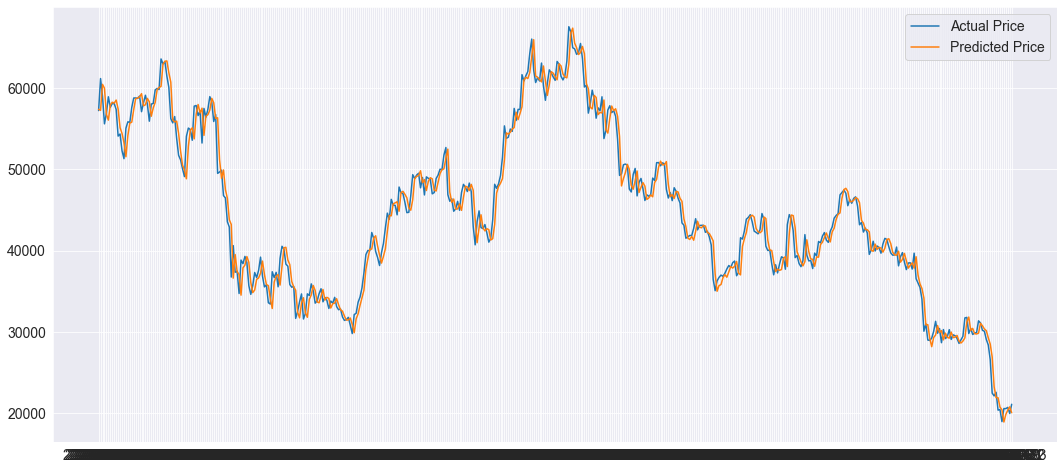

In [1280]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [1281]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [1282]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,19951.3,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,21086.7,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [1283]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [1284]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-22,20551.2,21698.9,20323.6,20701.9,5232.173565,33111.0,0.000054,0.031400,0.035597,0.007392,-0.270025,-0.123120,20789.985714,21618.242857,19425.700000,20588.028571,9153.220278,45512.714286,-0.033019,-0.033014,-0.013624,-0.011047,-0.017604,-0.035429,20965.255556,25763.700,29001.458
2022-06-23,20704.1,20860.1,19750.0,19951.3,6091.946677,33996.0,0.007440,-0.038656,-0.028223,-0.036258,0.164324,0.026728,20588.428571,21344.928571,19377.271429,20215.414286,7911.440431,40669.857143,-0.011040,-0.009674,-0.001331,-0.007770,0.000362,-0.010529,20686.500000,25239.915,28645.926


In [1285]:
X_train2 = X_train_new2.values
X_train2.shape

(3121, 27)

<b> y_train </b>

In [1286]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3121,)

#### 3. Test set is current trading day , today ( the last row)

In [1287]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-24,19951.3,21200.0,19880.4,21086.7,3813.637758,26182.0,-0.03636,0.016294,0.006603,0.056909,-0.373987,-0.229851,20216.185714,21094.928571,19331.614286,20318.328571,7328.775687,38812.571429,-0.007782,-0.011913,-0.000321,-0.015848,-0.034969,-0.02614,20572.688889,24810.43,28274.004


<b> y_actual </b>

#### 4. Model Prediciton

In [1288]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [1289]:
scaler = StandardScaler()

In [1290]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [1291]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [1292]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [1293]:
svr2 = SVR()

In [1294]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 29 µs, sys: 250 µs, total: 279 µs
Wall time: 840 µs


In [1295]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 16s, sys: 270 ms, total: 1min 16s
Wall time: 1min 16s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [1296]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 245 µs, sys: 167 µs, total: 412 µs
Wall time: 1.13 ms


In [1297]:
svr_best2 = grid_search2.best_estimator_

In [1298]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [1299]:
pred_svr_adjusted2

array([20868.55273297])

#### Create a new dataframe 

In [1300]:
new_cols = ["date","predict", "actual"]

In [1301]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [1302]:
df_actual["date"] = last_row.index
df_actual

,date,predict,actual
0,2022-06-24,NaN,NaN


In [1303]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-06-24,20868.552733,NaN


## Run Every Day

### Run at the End Of Day ( 5 p.m. Pacific Time)

In [1304]:
daily_predict = pd.read_csv("data/daily_predict.csv", index_col=0)
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Actual Result

In [1305]:
actual_close = btc_ml["close"][-1]
actual_close

21086.7

In [1306]:
#daily_predict.set_index("date")

In [1307]:
daily_predict["actual"][-1:] =  actual_close
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/2655483848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_predict["actual"][-1:] =  actual_close


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [1308]:
daily_predict["difference"] = daily_predict["predict"] - daily_predict["actual"]
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Store Updated data everyday

In [989]:
daily_predict = daily_predict.append(df_actual, ignore_index=True)
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30784/4107255893.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_predict = daily_predict.append(df_actual, ignore_index=True)


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [990]:
daily_predict.to_csv("data/daily_predict.csv")